In [1]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=1db9da272b9bde1ff42f3d38c7664d1c94e3a1011485653a476247a212b07eda
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-01-19 13:19:26--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-01-19 13:19:26--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  

In [2]:
!wget -O CRC-VAL-HE-7K.zip https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
!unzip -qq CRC-VAL-HE-7K.zip -d val

--2025-01-19 13:33:48--  https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800276929 (763M) [application/octet-stream]
Saving to: ‘CRC-VAL-HE-7K.zip’

CRC-VAL-HE-7K.zip   100%[===================>] 763.20M  24.2MB/s    in 32s     

2025-01-19 13:34:20 (23.7 MB/s) - ‘CRC-VAL-HE-7K.zip’ saved [800276929/800276929]



In [3]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary

In [4]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [5]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x


In [6]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [7]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [8]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [9]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [10]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x


In [11]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [12]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [14]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=4, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [38]:
model = LevitDistilled()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 64
learning_rate = 5e-4
decay_rate = 1e-6
num_epochs = 100

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [39]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [40]:
import random
import torchvision.transforms.functional as TF

class DataAugmentation:
    def __init__(self, p_hflip=0.5, p_vflip=0.5, p_noise=0.2, p_blur=0.2, p_color=0.2, p_contrast=0.2):
        self.p_hflip = p_hflip
        self.p_vflip = p_vflip
        self.p_noise = p_noise
        self.p_blur = p_blur
        self.p_color = p_color
        self.p_contrast = p_contrast
    def __call__(self, img):
        if random.random() < self.p_hflip:
            img = TF.hflip(img)

        if random.random() < self.p_vflip:
            img = TF.vflip(img)

        if random.random() < self.p_noise:
            # img.size is a tuple, so unpack it as arguments for torch.randn
            noise = torch.randn(*img.size()) * 0.1  # Changed img.size() to img.size
            img = torch.clamp(img + noise, 0, 1)

        if random.random() < self.p_blur:
            img = TF.gaussian_blur(img, kernel_size=(5, 5), sigma=(0.1, 5))

        if random.random() < self.p_color:
            img = TF.adjust_saturation(img, saturation_factor = random.uniform(0.5, 1.5))

        if random.random() < self.p_contrast:
            img = TF.adjust_contrast(img, contrast_factor = random.uniform(0.5, 1.5))

        return img

In [41]:
import torch
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# 데이터셋 경로
dataset_dir = './train/NCT-CRC-HE-100K'

# 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    DataAugmentation(),
])

# Using StratifiedShuffleSplit from sklearn

dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
data_paths, labels = zip(*dataset.samples)
labels = np.array(labels)

# 7 : 3 split
train_idx, tmp_idx, _, tmp_labels = train_test_split(
    np.arange(len(labels)), labels, test_size=0.3, stratify=labels, random_state=42
)

# 3 -> 1.5 : 1.5 split
val_idx, test_idx = train_test_split(
    tmp_idx, test_size=0.5, stratify=tmp_labels, random_state=42
)

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

In [42]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


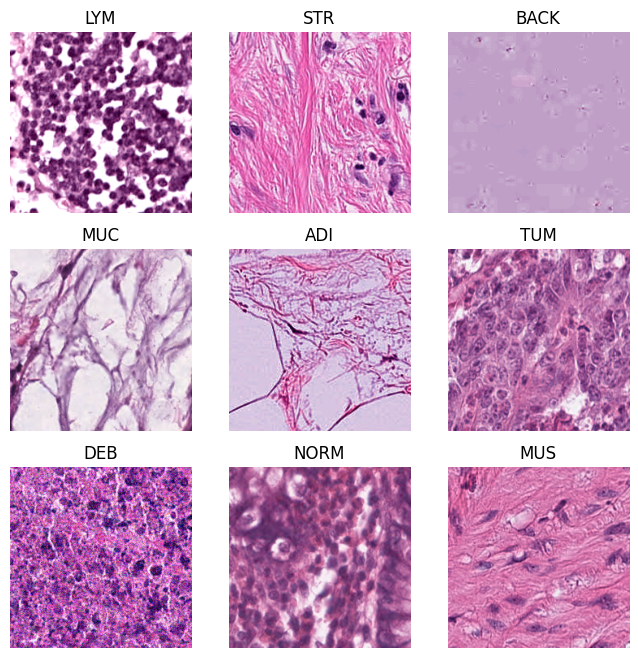

In [43]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(dataset.classes):
            break
    if len(class_examples) == len(dataset.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(dataset.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = decay_rate)

In [45]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [46]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [47]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [48]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [49]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.44it/s]


Train Loss: 0.6939, Train Accuracy: 75.34%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.40it/s]


Validation Loss: 0.4122, Validation Accuracy: 85.68%

Epoch 2/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.46it/s]


Train Loss: 0.3311, Train Accuracy: 88.45%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]


Validation Loss: 0.2830, Validation Accuracy: 89.97%

Epoch 3/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.49it/s]


Train Loss: 0.2562, Train Accuracy: 91.21%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]


Validation Loss: 0.2309, Validation Accuracy: 91.77%

Epoch 4/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.46it/s]


Train Loss: 0.2049, Train Accuracy: 93.03%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s]


Validation Loss: 0.1834, Validation Accuracy: 93.67%

Epoch 5/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.46it/s]


Train Loss: 0.1734, Train Accuracy: 94.13%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s]


Validation Loss: 0.2425, Validation Accuracy: 92.04%

Epoch 6/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.45it/s]


Train Loss: 0.1475, Train Accuracy: 94.96%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]


Validation Loss: 0.2192, Validation Accuracy: 92.35%

Epoch 7/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.48it/s]


Train Loss: 0.1287, Train Accuracy: 95.67%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]


Validation Loss: 0.1523, Validation Accuracy: 94.63%

Epoch 8/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.43it/s]


Train Loss: 0.1119, Train Accuracy: 96.24%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s]


Validation Loss: 0.2263, Validation Accuracy: 94.75%

Epoch 9/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.44it/s]


Train Loss: 0.1021, Train Accuracy: 96.51%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]


Validation Loss: 0.0820, Validation Accuracy: 97.42%

Epoch 10/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.46it/s]


Train Loss: 0.0913, Train Accuracy: 96.86%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s]


Validation Loss: 0.0933, Validation Accuracy: 96.77%

Epoch 11/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.56it/s]


Train Loss: 0.0815, Train Accuracy: 97.20%


Validation: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s]


Validation Loss: 0.0662, Validation Accuracy: 97.93%

Epoch 12/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.48it/s]


Train Loss: 0.0753, Train Accuracy: 97.45%


Validation: 100%|██████████| 469/469 [00:33<00:00, 14.07it/s]


Validation Loss: 0.0636, Validation Accuracy: 97.93%

Epoch 13/100


Training: 100%|██████████| 2188/2188 [03:12<00:00, 11.35it/s]


Train Loss: 0.0715, Train Accuracy: 97.58%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.57it/s]


Validation Loss: 0.0745, Validation Accuracy: 97.51%

Epoch 14/100


Training: 100%|██████████| 2188/2188 [03:08<00:00, 11.58it/s]


Train Loss: 0.0673, Train Accuracy: 97.75%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.36it/s]


Validation Loss: 0.0630, Validation Accuracy: 97.87%

Epoch 15/100


Training: 100%|██████████| 2188/2188 [03:08<00:00, 11.59it/s]


Train Loss: 0.0634, Train Accuracy: 97.89%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]


Validation Loss: 0.0561, Validation Accuracy: 98.11%

Epoch 16/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.56it/s]


Train Loss: 0.0582, Train Accuracy: 98.01%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.43it/s]


Validation Loss: 0.0822, Validation Accuracy: 97.19%

Epoch 17/100


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.32it/s]


Train Loss: 0.0545, Train Accuracy: 98.16%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.31it/s]


Validation Loss: 0.0767, Validation Accuracy: 97.55%

Epoch 18/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.47it/s]


Train Loss: 0.0523, Train Accuracy: 98.27%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]


Validation Loss: 0.0603, Validation Accuracy: 97.99%

Epoch 19/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.50it/s]


Train Loss: 0.0503, Train Accuracy: 98.32%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]


Validation Loss: 0.0538, Validation Accuracy: 98.27%

Epoch 20/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.47it/s]


Train Loss: 0.0468, Train Accuracy: 98.46%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.41it/s]


Validation Loss: 0.0731, Validation Accuracy: 97.61%

Epoch 21/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.48it/s]


Train Loss: 0.0455, Train Accuracy: 98.45%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s]


Validation Loss: 0.0689, Validation Accuracy: 97.92%

Epoch 22/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.51it/s]


Train Loss: 0.0426, Train Accuracy: 98.57%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s]


Validation Loss: 0.1467, Validation Accuracy: 95.51%

Epoch 23/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.49it/s]


Train Loss: 0.0404, Train Accuracy: 98.60%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]


Validation Loss: 0.0461, Validation Accuracy: 98.47%

Epoch 24/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.47it/s]


Train Loss: 0.0402, Train Accuracy: 98.66%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]


Validation Loss: 0.0460, Validation Accuracy: 98.68%

Epoch 25/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.42it/s]


Train Loss: 0.0381, Train Accuracy: 98.69%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]


Validation Loss: 0.0468, Validation Accuracy: 98.49%

Epoch 26/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.45it/s]


Train Loss: 0.0375, Train Accuracy: 98.77%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]


Validation Loss: 0.0433, Validation Accuracy: 98.62%

Epoch 27/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.49it/s]


Train Loss: 0.0345, Train Accuracy: 98.77%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s]


Validation Loss: 0.1645, Validation Accuracy: 94.87%

Epoch 28/100


Training: 100%|██████████| 2188/2188 [03:12<00:00, 11.38it/s]


Train Loss: 0.0358, Train Accuracy: 98.78%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.41it/s]


Validation Loss: 0.0443, Validation Accuracy: 98.55%

Epoch 29/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.46it/s]


Train Loss: 0.0332, Train Accuracy: 98.86%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.35it/s]


Validation Loss: 0.0424, Validation Accuracy: 98.67%

Epoch 30/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.41it/s]


Train Loss: 0.0318, Train Accuracy: 98.89%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]


Validation Loss: 0.0366, Validation Accuracy: 98.70%

Epoch 31/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.43it/s]


Train Loss: 0.0298, Train Accuracy: 98.95%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]


Validation Loss: 0.0532, Validation Accuracy: 98.43%

Epoch 32/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.42it/s]


Train Loss: 0.0316, Train Accuracy: 98.89%


Validation: 100%|██████████| 469/469 [00:33<00:00, 14.08it/s]


Validation Loss: 0.0440, Validation Accuracy: 98.57%

Epoch 33/100


Training: 100%|██████████| 2188/2188 [03:12<00:00, 11.37it/s]


Train Loss: 0.0290, Train Accuracy: 99.03%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s]


Validation Loss: 0.0489, Validation Accuracy: 98.49%

Epoch 34/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.47it/s]


Train Loss: 0.0286, Train Accuracy: 99.02%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s]


Validation Loss: 0.0365, Validation Accuracy: 98.79%

Epoch 35/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.47it/s]


Train Loss: 0.0282, Train Accuracy: 99.05%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.59it/s]


Validation Loss: 0.0820, Validation Accuracy: 97.35%

Epoch 36/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.45it/s]


Train Loss: 0.0287, Train Accuracy: 99.06%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]


Validation Loss: 0.0456, Validation Accuracy: 98.57%

Epoch 37/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.49it/s]


Train Loss: 0.0267, Train Accuracy: 99.11%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s]


Validation Loss: 0.0343, Validation Accuracy: 98.87%

Epoch 38/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.55it/s]


Train Loss: 0.0258, Train Accuracy: 99.14%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]


Validation Loss: 0.0356, Validation Accuracy: 98.83%

Epoch 39/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.51it/s]


Train Loss: 0.0265, Train Accuracy: 99.12%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s]


Validation Loss: 0.0362, Validation Accuracy: 98.89%

Epoch 40/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.52it/s]


Train Loss: 0.0254, Train Accuracy: 99.12%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s]


Validation Loss: 0.0498, Validation Accuracy: 98.43%

Epoch 41/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.51it/s]


Train Loss: 0.0246, Train Accuracy: 99.16%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s]


Validation Loss: 0.0438, Validation Accuracy: 98.65%

Epoch 42/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.51it/s]


Train Loss: 0.0252, Train Accuracy: 99.13%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s]


Validation Loss: 0.0341, Validation Accuracy: 98.98%

Epoch 43/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.50it/s]


Train Loss: 0.0230, Train Accuracy: 99.22%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s]


Validation Loss: 0.0335, Validation Accuracy: 98.95%

Epoch 44/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.56it/s]


Train Loss: 0.0237, Train Accuracy: 99.20%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s]


Validation Loss: 0.0348, Validation Accuracy: 98.85%

Epoch 45/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.52it/s]


Train Loss: 0.0220, Train Accuracy: 99.28%


Validation: 100%|██████████| 469/469 [00:31<00:00, 15.06it/s]


Validation Loss: 0.0472, Validation Accuracy: 98.58%

Epoch 46/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.48it/s]


Train Loss: 0.0219, Train Accuracy: 99.24%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]


Validation Loss: 0.0314, Validation Accuracy: 99.03%

Epoch 47/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.51it/s]


Train Loss: 0.0213, Train Accuracy: 99.30%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]


Validation Loss: 0.0465, Validation Accuracy: 98.45%

Epoch 48/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.50it/s]


Train Loss: 0.0220, Train Accuracy: 99.28%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.44it/s]


Validation Loss: 0.0390, Validation Accuracy: 98.89%

Epoch 49/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.48it/s]


Train Loss: 0.0224, Train Accuracy: 99.27%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]


Validation Loss: 0.0333, Validation Accuracy: 99.07%

Epoch 50/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.48it/s]


Train Loss: 0.0219, Train Accuracy: 99.25%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]


Validation Loss: 0.0365, Validation Accuracy: 98.81%

Epoch 51/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.54it/s]


Train Loss: 0.0185, Train Accuracy: 99.35%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s]


Validation Loss: 0.0296, Validation Accuracy: 99.04%

Epoch 52/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.53it/s]


Train Loss: 0.0207, Train Accuracy: 99.32%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]


Validation Loss: 0.0421, Validation Accuracy: 98.93%

Epoch 53/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.55it/s]


Train Loss: 0.0185, Train Accuracy: 99.36%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s]


Validation Loss: 0.0314, Validation Accuracy: 99.02%

Epoch 54/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.53it/s]


Train Loss: 0.0210, Train Accuracy: 99.27%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]


Validation Loss: 0.0383, Validation Accuracy: 98.83%

Epoch 55/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.52it/s]


Train Loss: 0.0199, Train Accuracy: 99.30%


Validation: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s]


Validation Loss: 0.0306, Validation Accuracy: 99.05%

Epoch 56/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.54it/s]


Train Loss: 0.0186, Train Accuracy: 99.35%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s]


Validation Loss: 0.0336, Validation Accuracy: 99.08%

Epoch 57/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.51it/s]


Train Loss: 0.0189, Train Accuracy: 99.38%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s]


Validation Loss: 0.0719, Validation Accuracy: 97.95%

Epoch 58/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.53it/s]


Train Loss: 0.0186, Train Accuracy: 99.37%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s]


Validation Loss: 0.0309, Validation Accuracy: 99.12%

Epoch 59/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.51it/s]


Train Loss: 0.0182, Train Accuracy: 99.35%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s]


Validation Loss: 0.0368, Validation Accuracy: 98.91%

Epoch 60/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.54it/s]


Train Loss: 0.0186, Train Accuracy: 99.37%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]


Validation Loss: 0.0310, Validation Accuracy: 99.17%

Epoch 61/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.48it/s]


Train Loss: 0.0174, Train Accuracy: 99.43%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.41it/s]


Validation Loss: 0.0461, Validation Accuracy: 98.75%

Epoch 62/100


Training: 100%|██████████| 2188/2188 [03:12<00:00, 11.39it/s]


Train Loss: 0.0172, Train Accuracy: 99.40%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s]


Validation Loss: 0.0385, Validation Accuracy: 98.77%

Epoch 63/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.51it/s]


Train Loss: 0.0163, Train Accuracy: 99.46%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s]


Validation Loss: 0.0378, Validation Accuracy: 98.93%

Epoch 64/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.42it/s]


Train Loss: 0.0178, Train Accuracy: 99.41%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]


Validation Loss: 0.0291, Validation Accuracy: 99.09%

Epoch 65/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.54it/s]


Train Loss: 0.0169, Train Accuracy: 99.44%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]


Validation Loss: 0.0443, Validation Accuracy: 98.78%

Epoch 66/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.50it/s]


Train Loss: 0.0180, Train Accuracy: 99.40%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]


Validation Loss: 0.0624, Validation Accuracy: 98.19%

Epoch 67/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.53it/s]


Train Loss: 0.0170, Train Accuracy: 99.42%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]


Validation Loss: 0.0421, Validation Accuracy: 98.97%

Epoch 68/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.54it/s]


Train Loss: 0.0186, Train Accuracy: 99.36%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]


Validation Loss: 0.0363, Validation Accuracy: 99.07%

Epoch 69/100


Training: 100%|██████████| 2188/2188 [03:09<00:00, 11.52it/s]


Train Loss: 0.0162, Train Accuracy: 99.45%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]


Validation Loss: 0.0282, Validation Accuracy: 99.05%

Epoch 70/100


Training: 100%|██████████| 2188/2188 [03:12<00:00, 11.38it/s]


Train Loss: 0.0168, Train Accuracy: 99.44%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]


Validation Loss: 0.0424, Validation Accuracy: 98.86%

Epoch 71/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.48it/s]


Train Loss: 0.0173, Train Accuracy: 99.43%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.35it/s]


Validation Loss: 0.0300, Validation Accuracy: 99.15%

Epoch 72/100


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.31it/s]


Train Loss: 0.0149, Train Accuracy: 99.48%


Validation: 100%|██████████| 469/469 [00:33<00:00, 14.15it/s]


Validation Loss: 0.0415, Validation Accuracy: 98.77%

Epoch 73/100


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.33it/s]


Train Loss: 0.0161, Train Accuracy: 99.48%


Validation: 100%|██████████| 469/469 [00:33<00:00, 14.17it/s]


Validation Loss: 0.0245, Validation Accuracy: 99.21%

Epoch 74/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.47it/s]


Train Loss: 0.0140, Train Accuracy: 99.52%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s]


Validation Loss: 0.0324, Validation Accuracy: 99.05%

Epoch 75/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.43it/s]


Train Loss: 0.0158, Train Accuracy: 99.49%


Validation: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s]


Validation Loss: 0.0275, Validation Accuracy: 99.20%

Epoch 76/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.42it/s]


Train Loss: 0.0148, Train Accuracy: 99.49%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]


Validation Loss: 0.0430, Validation Accuracy: 98.71%

Epoch 77/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.51it/s]


Train Loss: 0.0153, Train Accuracy: 99.50%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]


Validation Loss: 0.0332, Validation Accuracy: 99.17%

Epoch 78/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.44it/s]


Train Loss: 0.0153, Train Accuracy: 99.49%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s]


Validation Loss: 0.0343, Validation Accuracy: 99.04%

Epoch 79/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.46it/s]


Train Loss: 0.0151, Train Accuracy: 99.51%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]


Validation Loss: 0.0331, Validation Accuracy: 98.97%

Epoch 80/100


Training: 100%|██████████| 2188/2188 [03:12<00:00, 11.37it/s]


Train Loss: 0.0144, Train Accuracy: 99.50%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]


Validation Loss: 0.0366, Validation Accuracy: 98.88%

Epoch 81/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.50it/s]


Train Loss: 0.0144, Train Accuracy: 99.52%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s]


Validation Loss: 0.0365, Validation Accuracy: 98.87%

Epoch 82/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.41it/s]


Train Loss: 0.0157, Train Accuracy: 99.50%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s]


Validation Loss: 0.0297, Validation Accuracy: 99.17%

Epoch 83/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.48it/s]


Train Loss: 0.0134, Train Accuracy: 99.54%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.40it/s]


Validation Loss: 0.0246, Validation Accuracy: 99.31%

Epoch 84/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.45it/s]


Train Loss: 0.0147, Train Accuracy: 99.51%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.27it/s]


Validation Loss: 0.0506, Validation Accuracy: 98.45%

Epoch 85/100


Training: 100%|██████████| 2188/2188 [03:12<00:00, 11.35it/s]


Train Loss: 0.0141, Train Accuracy: 99.52%


Validation: 100%|██████████| 469/469 [00:33<00:00, 14.12it/s]


Validation Loss: 0.0282, Validation Accuracy: 99.11%

Epoch 86/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.41it/s]


Train Loss: 0.0141, Train Accuracy: 99.55%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.37it/s]


Validation Loss: 0.0218, Validation Accuracy: 99.33%

Epoch 87/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.49it/s]


Train Loss: 0.0131, Train Accuracy: 99.56%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.36it/s]


Validation Loss: 0.0296, Validation Accuracy: 99.19%

Epoch 88/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.46it/s]


Train Loss: 0.0139, Train Accuracy: 99.53%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]


Validation Loss: 0.0321, Validation Accuracy: 99.11%

Epoch 89/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.46it/s]


Train Loss: 0.0139, Train Accuracy: 99.57%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]


Validation Loss: 0.0313, Validation Accuracy: 99.07%

Epoch 90/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.42it/s]


Train Loss: 0.0132, Train Accuracy: 99.54%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]


Validation Loss: 0.0332, Validation Accuracy: 99.04%

Epoch 91/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.49it/s]


Train Loss: 0.0139, Train Accuracy: 99.52%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.37it/s]


Validation Loss: 0.0552, Validation Accuracy: 98.40%

Epoch 92/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.46it/s]


Train Loss: 0.0138, Train Accuracy: 99.52%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.35it/s]


Validation Loss: 0.0294, Validation Accuracy: 99.17%

Epoch 93/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.45it/s]


Train Loss: 0.0137, Train Accuracy: 99.54%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]


Validation Loss: 0.0378, Validation Accuracy: 98.93%

Epoch 94/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.46it/s]


Train Loss: 0.0132, Train Accuracy: 99.53%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]


Validation Loss: 0.0435, Validation Accuracy: 98.70%

Epoch 95/100


Training: 100%|██████████| 2188/2188 [03:11<00:00, 11.43it/s]


Train Loss: 0.0123, Train Accuracy: 99.57%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]


Validation Loss: 0.0424, Validation Accuracy: 98.90%

Epoch 96/100


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.29it/s]


Train Loss: 0.0121, Train Accuracy: 99.60%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]


Validation Loss: 0.0319, Validation Accuracy: 99.12%

Epoch 97/100


Training: 100%|██████████| 2188/2188 [03:12<00:00, 11.37it/s]


Train Loss: 0.0141, Train Accuracy: 99.54%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.59it/s]


Validation Loss: 0.0301, Validation Accuracy: 99.09%

Epoch 98/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.47it/s]


Train Loss: 0.0128, Train Accuracy: 99.58%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]


Validation Loss: 0.0382, Validation Accuracy: 99.00%

Epoch 99/100


Training: 100%|██████████| 2188/2188 [03:10<00:00, 11.46it/s]


Train Loss: 0.0121, Train Accuracy: 99.58%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s]


Validation Loss: 0.0328, Validation Accuracy: 98.97%

Epoch 100/100


Training: 100%|██████████| 2188/2188 [03:12<00:00, 11.36it/s]


Train Loss: 0.0135, Train Accuracy: 99.57%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]

Validation Loss: 0.0297, Validation Accuracy: 99.05%


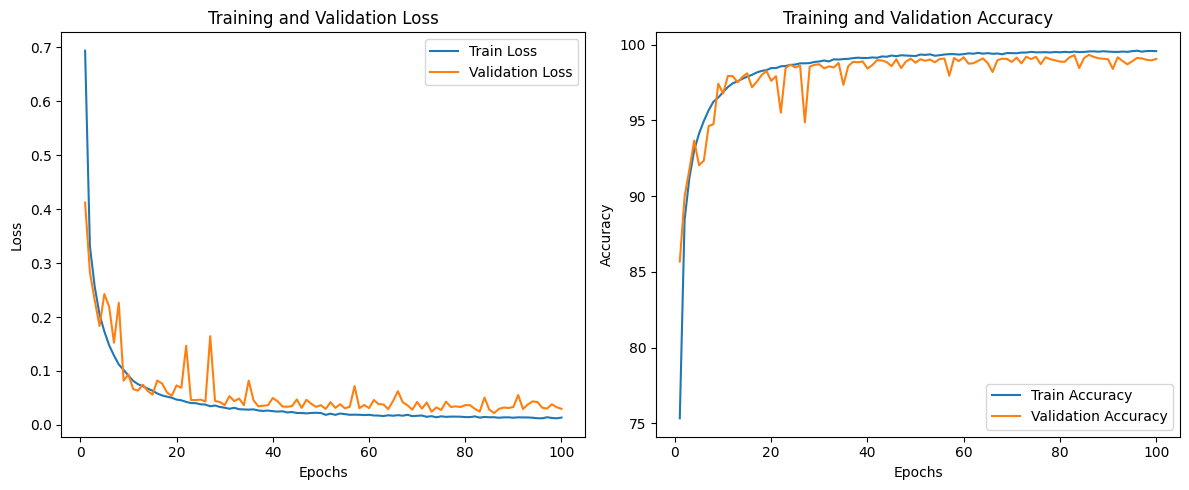

In [50]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 7.53 ms
Standard Deviation: 0.62 ms
Maximum Time: 11.90 ms
Minimum Time: 7.11 ms


In [52]:
evaluate(model, test_loader, criterion, device)

Validation: 100%|██████████| 469/469 [00:32<00:00, 14.26it/s]

Validation Loss: 0.0390, Validation Accuracy: 98.93%


In [53]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.19%     418.566us        21.32%       4.083ms     113.420us       0.000us         0.00%       4.227ms     117.404us            36  
                                           aten::linear         0.87%     166.189us        15.17%       2.905ms     111.729us       0.000us         0.00%       2.909ms     111.896us            26  
         

In [55]:
save_path = "HoViT42_100epoch_NCT_CRC_HE_agu.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT42_100epoch_NCT_CRC_HE_agu.pth


In [32]:
save_path = "HoViT44_NCT_CRC_HE_agu.pth"
model.load_state_dict(torch.load(save_path))

<ipython-input-32-fd3cb7b224e5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


<All keys matched successfully>

In [56]:
# 데이터셋 경로
dataset_dir = './val/CRC-VAL-HE-7K'

# 변환 설정
transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #DataAugmentation(),
])

# 데이터셋 로드
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

In [57]:
from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_labels_binarized = label_binarize(all_labels, classes=class_labels)
    fpr, tpr, _ = roc_curve(all_labels_binarized.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

Validation: 100%|██████████| 225/225 [00:10<00:00, 20.98it/s]


Validation Loss: 0.8320, Validation Accuracy: 92.08%
Overall - F1: 0.9016, Recall: 0.9106, Precision: 0.8967
Per-Class Metrics:
Class 0 - F1: 0.9483, Recall: 0.9245, Precision: 0.9732
Class 1 - F1: 0.9592, Recall: 1.0000, Precision: 0.9217
Class 2 - F1: 0.8832, Recall: 0.9705, Precision: 0.8103
Class 3 - F1: 0.9776, Recall: 1.0000, Precision: 0.9563
Class 4 - F1: 0.9235, Recall: 0.8744, Precision: 0.9784
Class 5 - F1: 0.7283, Recall: 0.6791, Precision: 0.7852
Class 6 - F1: 0.9090, Recall: 0.9568, Precision: 0.8657
Class 7 - F1: 0.8104, Recall: 0.8124, Precision: 0.8085
Class 8 - F1: 0.9745, Recall: 0.9781, Precision: 0.9710
Balanced Accuracy: 0.9106


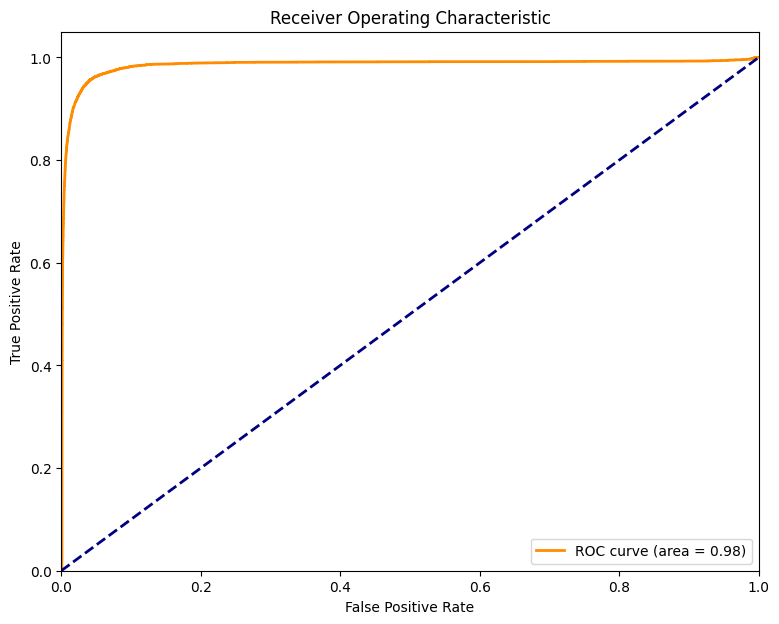

In [58]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, full_loader, criterion, device)

<Figure size 2000x1200 with 0 Axes>

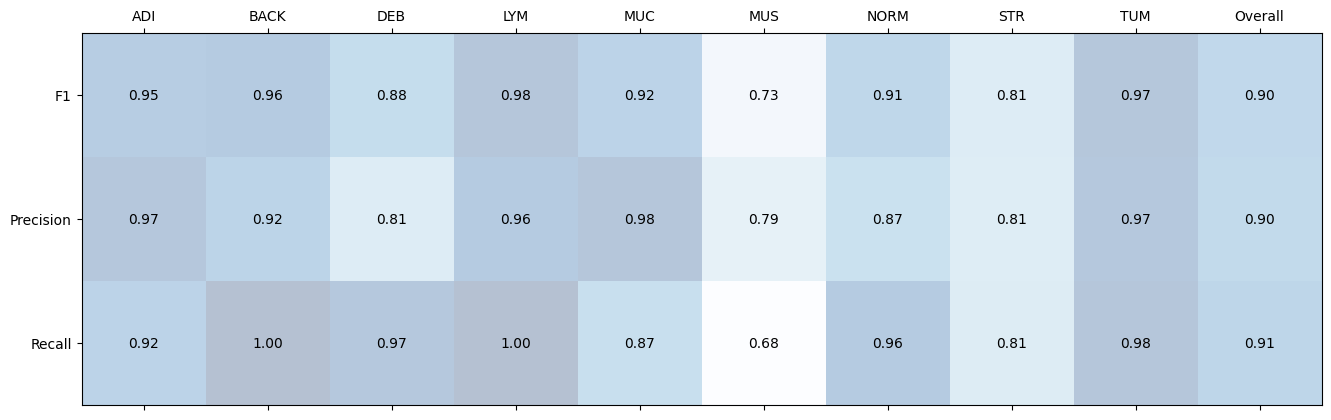

In [59]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [60]:
from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.flip(2))
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_labels_binarized = label_binarize(all_labels, classes=class_labels)
    fpr, tpr, _ = roc_curve(all_labels_binarized.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

Validation: 100%|██████████| 225/225 [00:10<00:00, 20.98it/s]


Validation Loss: 0.8094, Validation Accuracy: 92.33%
Overall - F1: 0.9061, Recall: 0.9154, Precision: 0.9005
Per-Class Metrics:
Class 0 - F1: 0.9458, Recall: 0.9200, Precision: 0.9731
Class 1 - F1: 0.9565, Recall: 1.0000, Precision: 0.9167
Class 2 - F1: 0.9078, Recall: 0.9735, Precision: 0.8505
Class 3 - F1: 0.9845, Recall: 1.0000, Precision: 0.9694
Class 4 - F1: 0.9214, Recall: 0.8667, Precision: 0.9836
Class 5 - F1: 0.7315, Recall: 0.6926, Precision: 0.7750
Class 6 - F1: 0.9186, Recall: 0.9744, Precision: 0.8688
Class 7 - F1: 0.8083, Recall: 0.8314, Precision: 0.7865
Class 8 - F1: 0.9801, Recall: 0.9797, Precision: 0.9805
Balanced Accuracy: 0.9154


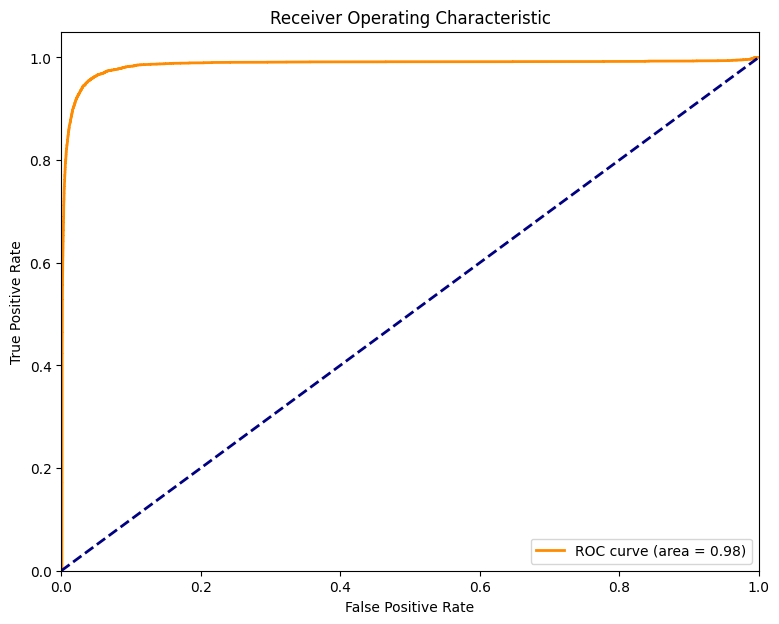

In [61]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, full_loader, criterion, device)

<Figure size 2000x1200 with 0 Axes>

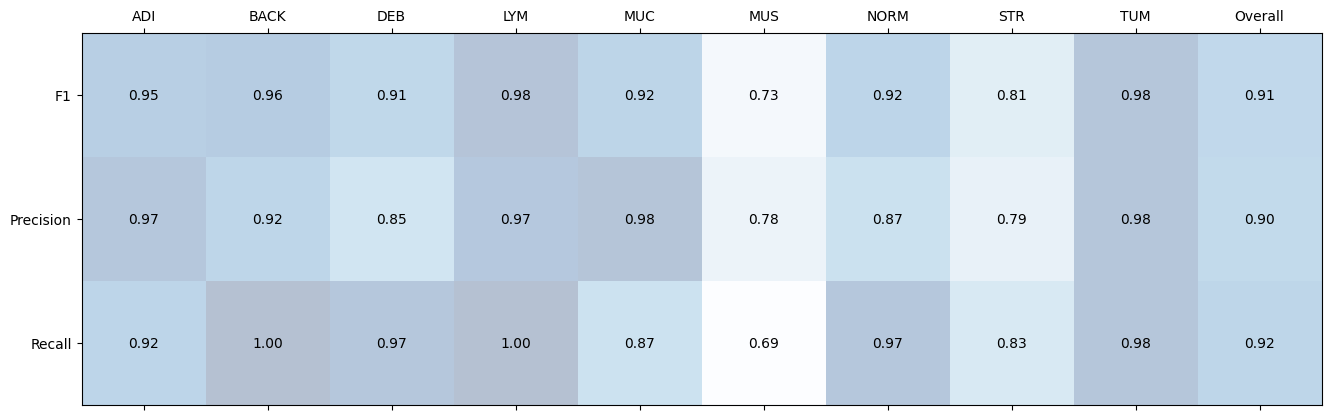

In [62]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [63]:
from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.flip(3))
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_labels_binarized = label_binarize(all_labels, classes=class_labels)
    fpr, tpr, _ = roc_curve(all_labels_binarized.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

Validation: 100%|██████████| 225/225 [00:10<00:00, 21.24it/s]


Validation Loss: 0.8064, Validation Accuracy: 92.55%
Overall - F1: 0.9072, Recall: 0.9163, Precision: 0.9017
Per-Class Metrics:
Class 0 - F1: 0.9494, Recall: 0.9260, Precision: 0.9741
Class 1 - F1: 0.9598, Recall: 1.0000, Precision: 0.9227
Class 2 - F1: 0.8907, Recall: 0.9735, Precision: 0.8209
Class 3 - F1: 0.9822, Recall: 1.0000, Precision: 0.9650
Class 4 - F1: 0.9287, Recall: 0.8812, Precision: 0.9817
Class 5 - F1: 0.7404, Recall: 0.7010, Precision: 0.7845
Class 6 - F1: 0.9245, Recall: 0.9744, Precision: 0.8794
Class 7 - F1: 0.8109, Recall: 0.8147, Precision: 0.8071
Class 8 - F1: 0.9780, Recall: 0.9757, Precision: 0.9804
Balanced Accuracy: 0.9163


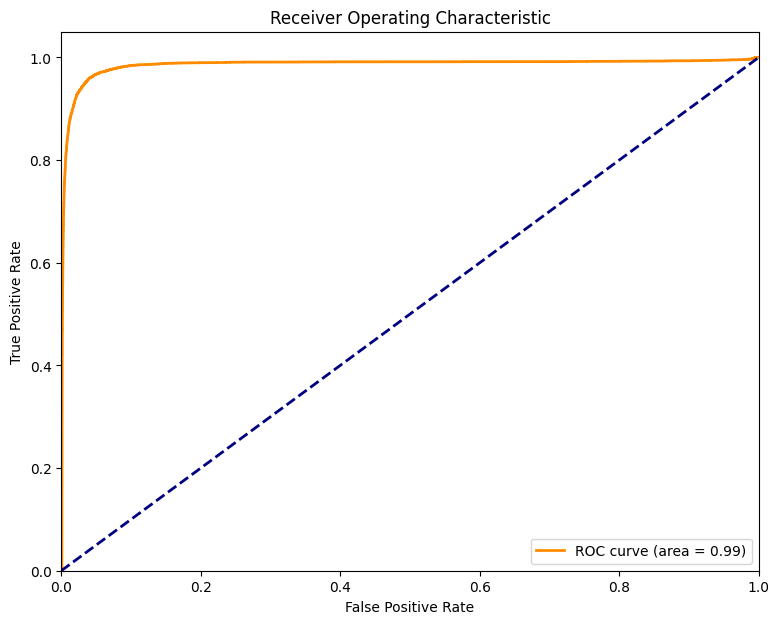

In [64]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, full_loader, criterion, device)

<Figure size 2000x1200 with 0 Axes>

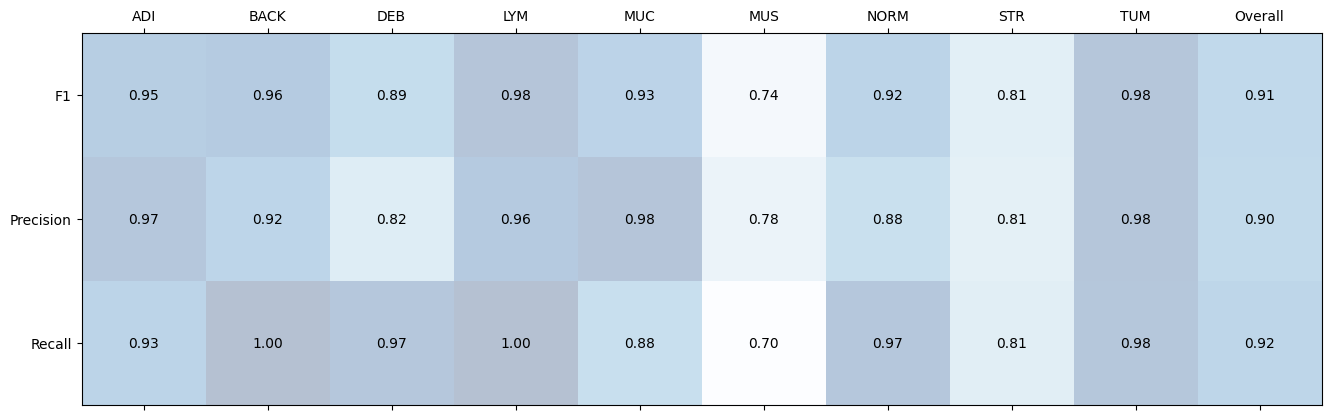

In [65]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [66]:
from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.flip(2).flip(3))
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_labels_binarized = label_binarize(all_labels, classes=class_labels)
    fpr, tpr, _ = roc_curve(all_labels_binarized.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

Validation: 100%|██████████| 225/225 [00:10<00:00, 21.20it/s]


Validation Loss: 0.7940, Validation Accuracy: 92.41%
Overall - F1: 0.9072, Recall: 0.9164, Precision: 0.9022
Per-Class Metrics:
Class 0 - F1: 0.9506, Recall: 0.9275, Precision: 0.9749
Class 1 - F1: 0.9592, Recall: 1.0000, Precision: 0.9217
Class 2 - F1: 0.8868, Recall: 0.9705, Precision: 0.8164
Class 3 - F1: 0.9807, Recall: 1.0000, Precision: 0.9621
Class 4 - F1: 0.9188, Recall: 0.8638, Precision: 0.9813
Class 5 - F1: 0.7455, Recall: 0.7027, Precision: 0.7939
Class 6 - F1: 0.9121, Recall: 0.9730, Precision: 0.8583
Class 7 - F1: 0.8351, Recall: 0.8361, Precision: 0.8341
Class 8 - F1: 0.9756, Recall: 0.9740, Precision: 0.9772
Balanced Accuracy: 0.9164


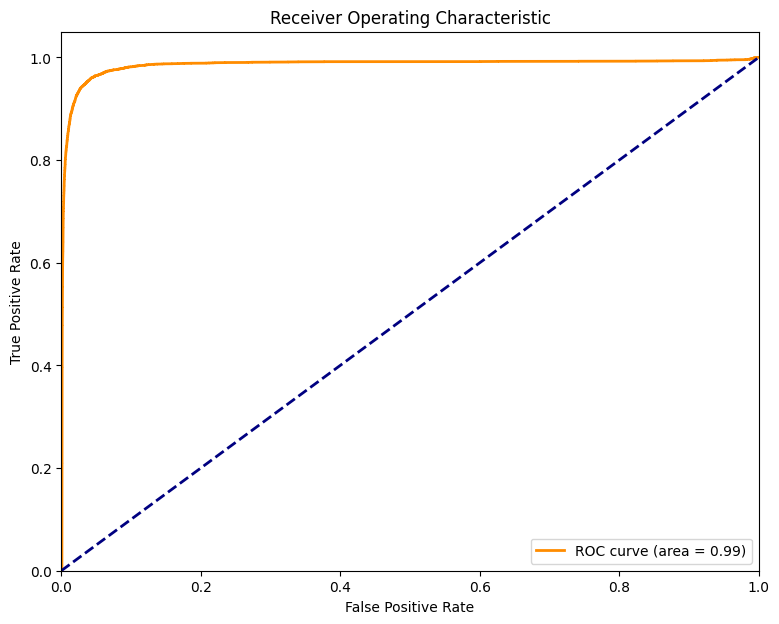

In [67]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, full_loader, criterion, device)

<Figure size 2000x1200 with 0 Axes>

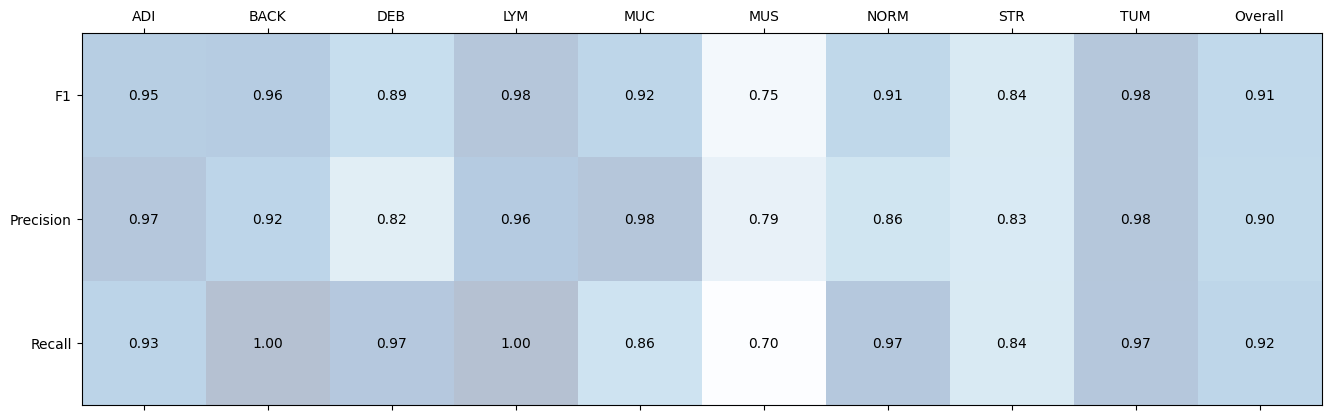

In [68]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )